Siempre al inicializar la session de kaggle

In [3]:
!pip install ultralytics opencv-python --quiet
!pip install open_clip_torch --quiet
print("All requirements satisfied")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
All requirements satisfied


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Only in kaggle to load local code modules

In [4]:
import sys
sys.path.append("/kaggle/input/python-modules/modules")
print("Modules imported succesfully")

Modules imported succesfully


In [5]:
from yolo_detector import YOLODetector
from clip_classifier import CLIPClassifier

# Rutas de entrada y salida
INPUT_DIR = "/kaggle/input/input1/input"
OUTPUT_DIR = "/kaggle/working/output"

# Ruta a los modelos entrenados
YOLO_MODEL_PATH = "/kaggle/input/yolov8-sku110k/pytorch/default/1/best.pt"
CLIP_MODEL_PATH = "/kaggle/input/open-clip/pytorch/default/1/open_clip_model.safetensors"

# Inicializar detector y clasificador
detector = YOLODetector(model_path=YOLO_MODEL_PATH)  
classifier = CLIPClassifier(checkpoint_path=CLIP_MODEL_PATH)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ YOLO model loaded from: /kaggle/input/yolov8-sku110k/pytorch/default/1/best.pt
Using device: cuda


✅ CLIP model loaded from checkpoint: /kaggle/input/open-clip/pytorch/default/1/open_clip_model.safetensors


Inicializa base de datos.

In [6]:
from inventory_db import InventoryDB

inventory_db = InventoryDB()

✅ Inventory database initialized.


Inferencia del modelo

In [7]:
from reporter import BatchYOLOReporter

reporter = BatchYOLOReporter(detector)

reporter.snapshot_invetory(INPUT_DIR)

Procesando 1 imágenes...

 Proceso terminado.


In [7]:
import os

def list_snapshots(output_dir="/kaggle/working/output"):
    return sorted(
        [
            os.path.join(output_dir, d)
            for d in os.listdir(output_dir)
            if os.path.isdir(os.path.join(output_dir, d))
        ],
        reverse=True
    )


snapshots = list_snapshots()
print(snapshots)
reporter.print_summary(snapshots[0])

['/kaggle/working/output/2026-01-13_17-15-30']

 RESUMEN DE DETECCIONES DE /kaggle/working/output/2026-01-13_17-15-30
SECCION-BEBIDAS-5    -> 237  productos


In [ ]:
reporter.show_summary(latest_snapshot)

In [ ]:
section_products = {
    "SECCION-BEBIDAS-5": ["coca_cola", "cola_cola_zero", "coca_cola_diet", "fanta", "pepsi", "sprite", "dr_pepper", "dr_pepper_diet"],
    "SECCION-BEBIDAS-4": ["fiesta_strawberry", "fiesta_lime", "fiesta_colas", "fiesta_root_beer", "fiesta_orange", "fiesta_grape", "island_sun_peach"],
}


In [ ]:
print(latest_snapshot)

In [ ]:
import os

folder_path = latest_snapshot

folder_name = os.path.basename(folder_path)

csv_path = os.path.join(
    folder_path,
    f"bboxes_{folder_name}.csv"
)

print(csv_path)

Clasificacion por comapracion de embeddings

generate embedings

In [ ]:
import torch
import timm
from PIL import Image
from torchvision import transforms
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import cv2
import tqdm  # optional, for progress bar
import os

# ---------------- CONFIG ----------------
DBSCAN_EPS = 0.35
DBSCAN_MIN_SAMPLES = 3

# ---- Load CSV ----
df = pd.read_csv(csv_path)
print("Total ROIs in CSV:", len(df))

# --- Load DINOv2 model ---
model = timm.create_model("vit_large_patch14_dinov2", pretrained=True)
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# --- Preprocessing ---
# DINOv2 large_patch14 expects 518x518 input
input_size = 518
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

def dino_embedding(roi_np):
    print("Original ROI shape:", roi_np.shape)  # debug
    img = Image.fromarray(roi_np)
    x = transform(img).unsqueeze(0).to(device)
    print("Transformed tensor shape:", x.shape)  # debug
    with torch.no_grad():
        feats = model.forward_features(x)
        emb = feats[:, 0]  # CLS token
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu().numpy().squeeze()

# --- Generate embeddings ---
embeddings = []
roi_ids = []

for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(INPUT_DIR, row["image_file"])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x1, y1, x2, y2 = eval(row["bbox:"])
    roi = img[int(y1):int(y2), int(x1):int(x2)]
    
    if roi.size == 0:
        print(f"Skipping empty ROI at idx={idx}, coords={x1,y1,x2,y2}")
        continue
    
    emb = dino_embedding(roi)
    embeddings.append(emb)
    roi_ids.append(idx)

X = np.vstack(embeddings)
X = normalize(X)

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import numpy as np

# ----------------- CONFIG -----------------
KMEANS_K = 10
DBSCAN_EPS = 0.20
DBSCAN_MIN_SAMPLES = 3
# ------------------------------------------

# ---------- KMEANS ----------
kmeans = KMeans(n_clusters=KMEANS_K, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

# ---------- DBSCAN ----------
dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES, metric="cosine")
labels_dbscan = dbscan.fit_predict(X)

# ---------- PCA ----------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# ---------- UMAP ----------
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X)

# ---------- Helper: plot with legend ----------
def plot_clusters(ax, X2d, labels, title):
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap("tab20", len(unique_labels))

    for i, lab in enumerate(unique_labels):
        mask = labels == lab
        if lab == -1:
            ax.scatter(X2d[mask, 0], X2d[mask, 1], c="k", s=10, alpha=0.3, label="noise")
        else:
            ax.scatter(X2d[mask, 0], X2d[mask, 1], color=cmap(i), s=10, label=f"cluster {lab}")

    ax.set_title(title)
    ax.legend(markerscale=2, fontsize=8)

# ---------- Plot ----------
plt.figure(figsize=(16, 14))

# 1) KMeans + PCA
ax = plt.subplot(2, 2, 1)
plot_clusters(ax, X_pca, labels_kmeans, "KMeans + PCA")

# 2) KMeans + UMAP
ax = plt.subplot(2, 2, 2)
plot_clusters(ax, X_umap, labels_kmeans, "KMeans + UMAP")

# 3) DBSCAN + PCA
ax = plt.subplot(2, 2, 3)
plot_clusters(ax, X_pca, labels_dbscan, "DBSCAN + PCA")

# 4) DBSCAN + UMAP
ax = plt.subplot(2, 2, 4)
plot_clusters(ax, X_umap, labels_dbscan, "DBSCAN + UMAP")

plt.tight_layout()
plt.show()

# ---------- Print stats ----------
print("========== STATS ==========")
print("KMeans clusters:", len(set(labels_kmeans)))
print("DBSCAN clusters (excluding noise):", len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0))
print("DBSCAN noise points:", np.sum(labels_dbscan == -1))


cluster embedings

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import math

# ---------------- CONFIG ----------------
MAX_PER_CLUSTER = 36   # max images to show per cluster
GRID = 6               # 6x6 grid
SKIP_NOISE = True      # skip cluster -1
# --------------------------------------

# Make sure bbox column name is correct
BBOX_COL = "bbox" if "bbox" in df.columns else "bbox:"

# Iterate clusters
clusters = sorted(df["cluster"].unique())

for cluster_id in clusters:

    if cluster_id == -1 and SKIP_NOISE:
        continue

    subset = df[df["cluster"] == cluster_id]

    if len(subset) == 0:
        continue

    print(f"\n=== CLUSTER {cluster_id} | {len(subset)} ROIs ===")

    subset = subset.iloc[:MAX_PER_CLUSTER]

    n = len(subset)
    cols = GRID
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 2, rows * 2))

    for i, (_, row) in enumerate(subset.iterrows()):
        img_path = os.path.join(INPUT_DIR, row["image_file"])
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        x1, y1, x2, y2 = eval(row[BBOX_COL])
        roi = image[int(y1):int(y2), int(x1):int(x2)]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(roi)
        plt.axis("off")

    plt.suptitle(f"Cluster {cluster_id} — {len(subset)} samples", fontsize=16)
    plt.tight_layout()
    plt.show()


Clasificacion con LVM

In [ ]:
import pandas as pd
import cv2
import os

# CSV original (sin predicciones)
df = pd.read_csv(csv_path)

# Si la columna predicted_label no existe, la creamos vacía
if "predicted_label" not in df.columns:
    df["predicted_label"] = ""

# Procesar cada ROI y agregar la predicción
for idx, row in df.iterrows():
    img_path = os.path.join(INPUT_DIR, row["image_file"])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    x1, y1, x2, y2 = eval(row["bbox:"])
    roi = image[int(y1):int(y2), int(x1):int(x2)]
    
    section = row["section"]
    class_names = section_products.get(section, [])
    
    if class_names:
        predicted = classifier.classify(roi, class_names)
    else:
        predicted = "No classes for section"
    
    # Guardar la predicción en la nueva columna
    df.at[idx, "predicted_label"] = predicted

# Sobrescribir el CSV original con la nueva columna al final
df.to_csv(csv_path, index=False)

print(f"CSV actualizado: {csv_path} (columna predicted_label añadida al final)")


Muestra las imagenes con matplotlib

In [ ]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import math

# INPUT_DIR debe estar definido como antes
# INPUT_DIR = "ruta_a_tus_imagenes"

# Leer CSV con predicciones
df = pd.read_csv(csv_path)

# Obtener todas las clases únicas predichas
all_classes = df["predicted_label"].unique()

# Número de imágenes por fila en el grid
images_per_row = 5

for cls in all_classes:
    if cls == "":
        continue  # saltar filas sin predicción
    
    # Filtrar filas que corresponden a esta clase
    cls_rows = df[df["predicted_label"] == cls]
    num_images = len(cls_rows)
    if num_images == 0:
        continue
    
    print(f"\n=== Clase: {cls} ({num_images} imágenes) ===")
    
    # Calcular número de filas necesarias en el grid
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row*3, num_rows*3))
    axes = axes.flatten()  # Para poder indexar fácilmente aunque sea 1 fila
    
    for ax_idx, (_, row) in enumerate(cls_rows.iterrows()):
        img_path = os.path.join(INPUT_DIR, row["image_file"])
        image = cv2.imread(img_path)
        if image is None:
            print(f"Imagen no encontrada: {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        x1, y1, x2, y2 = eval(row["bbox:"])
        roi = image[int(y1):int(y2), int(x1):int(x2)]
        
        axes[ax_idx].imshow(roi)
        axes[ax_idx].axis("off")
    
    # Ocultar ejes sobrantes si hay
    for j in range(ax_idx+1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Leer CSV con predicciones
df = pd.read_csv(csv_path)

# Contar cantidad de apariciones de cada clase
class_counts = df["predicted_label"].value_counts()

print("Cantidad de apariciones por clase:")
print(class_counts)


In [ ]:
import pandas as pd
import os

# CSV con predicciones
df = pd.read_csv(csv_path)

# Contar cantidad de apariciones de cada clase
class_counts = df["predicted_label"].value_counts().to_dict()  # {'coca_cola': 10, 'fanta': 12, ...}

# Extraer timestamp del nombre del CSV
basename = os.path.basename(csv_path)          # 'bboxes_2026-01-07_16-31-08.csv'
name_without_ext = os.path.splitext(basename)[0]  # 'bboxes_2026-01-07_16-31-08'
parts = name_without_ext.split("_")            # ['bboxes', '2026-01-07', '16-31-08']
timestamp_str = parts[1] + "_" + parts[2]     # '2026-01-07_16-31-08'

timestamp = pd.to_datetime(timestamp_str, format="%Y-%m-%d_%H-%M-%S")

# Construir fila a insertar: primero el timestamp
row_to_insert = {"timestamp": timestamp}
row_to_insert.update(class_counts)  # agregamos dinámicamente los productos

# Guardar en la base de datos
inventory_db.insert_row(row_to_insert)

print("Fila agregada a InventoryDB:")
print(row_to_insert)
inventory_db.show()


In [ ]:
# -------------------------------
# Simulate a "realistic" decreasing inventory
# -------------------------------

import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

products = ["coke_can", "pringles", "evian_water", "snickers", "lays"]

# Number of snapshots
num_snapshots = 5
base_time = datetime.now() - timedelta(days=1)

snapshots = []

# Step 1: Initialize starting counts
start_counts = {p: random.randint(15, 25) for p in products}

# Step 2: Generate decreasing counts over time
for i in range(num_snapshots):
    timestamp = base_time + timedelta(hours=i*6)
    snapshot = {}
    for p in products:
        # Decrease by random amount between 0 and 5, but never below 0
        if i == 0:
            snapshot[p] = start_counts[p]
        else:
            snapshot[p] = max(snapshots[-1][p] - random.randint(0, 5), 0)
    snapshot["timestamp"] = timestamp
    snapshots.append(snapshot)

# Convert to DataFrame
db_mock = pd.DataFrame(snapshots)
print("Simulated 'decreasing' DB:")
db_mock

In [ ]:
# -------------------------------
# Cell 2: Load inventory variables
# -------------------------------

# Choose two snapshots to compare
snapshot1 = db_mock.iloc[0]  # earliest snapshot
snapshot2 = db_mock.iloc[-1] # latest snapshot

# Convert to dictionaries for plotting
inventory1 = {p: snapshot1[p] for p in products}
inventory2 = {p: snapshot2[p] for p in products}

# Save timestamps as metadata
timestamp1 = snapshot1["timestamp"]
timestamp2 = snapshot2["timestamp"]

print("Inventory 1:", inventory1)
print("Inventory 2:", inventory2)
print("Timestamps:", timestamp1, "->", timestamp2)


In [ ]:
# -------------------------------
# Cell 3: Print graphs
# -------------------------------

import matplotlib.pyplot as plt

# --- Graph 1: Counts per class ---
x = range(len(products))

plt.figure(figsize=(10, 5))
plt.bar([i-0.15 for i in x], [inventory1[p] for p in products], width=0.3, label=f"T1: {timestamp1}")
plt.bar([i+0.15 for i in x], [inventory2[p] for p in products], width=0.3, label=f"T2: {timestamp2}")
plt.xticks(x, products)
plt.ylabel("Item Count")
plt.title("Product Counts per Class")
plt.legend()
plt.show()

# --- Graph 2: Items added / removed ---
diff = {p: inventory2[p] - inventory1[p] for p in products}
colors = ['green' if v >= 0 else 'red' for v in diff.values()]

plt.figure(figsize=(10, 5))
plt.bar(products, diff.values(), color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Items Added/Removed")
plt.title(f"Inventory Changes from {timestamp1} to {timestamp2}")
plt.show()

# -------------------------------
# Line plot: Evolution of products over time
# -------------------------------

# Extract timestamps
timestamps = db_mock["timestamp"]

plt.figure(figsize=(12, 6))

# Plot each product as a line
for product in products:
    plt.plot(timestamps, db_mock[product], marker='o', label=product)

plt.xlabel("Timestamp")
plt.ylabel("Item Count")
plt.title("Inventory Evolution Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd

threshold = 3  # stock shortage threshold

# Convert timestamps to numeric values (hours since first snapshot)
X = np.array([(t - db_mock["timestamp"].iloc[0]).total_seconds()/3600 for t in db_mock["timestamp"]]).reshape(-1, 1)

for product in products:
    y = db_mock[product].values

    plt.figure(figsize=(8, 5))

    # Plot actual inventory points
    plt.plot(db_mock["timestamp"], y, 'o-', label=f"{product} (actual)")

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Predict future trend (extend 24 hours beyond last snapshot)
    future_hours = np.linspace(0, X[-1][0]+24, 100).reshape(-1, 1)
    y_pred = model.predict(future_hours)
    future_times = [db_mock["timestamp"].iloc[0] + pd.Timedelta(hours=h[0]) for h in future_hours]

    # Plot predicted line
    plt.plot(future_times, y_pred, '--', label=f"{product} (predicted)")

    # Find crossing point with threshold
    if model.coef_[0] != 0:
        hours_to_threshold = (threshold - model.intercept_) / model.coef_[0]
        if hours_to_threshold > 0:
            t_cross = db_mock["timestamp"].iloc[0] + pd.Timedelta(hours=hours_to_threshold)
            plt.plot(t_cross, threshold, 'rx', markersize=10)
            plt.text(t_cross, threshold+0.5, f"Predicted shortage", color='red')

    # Draw threshold line
    plt.axhline(y=threshold, color='gray', linestyle='--', label=f"Threshold = {threshold}")

    plt.xlabel("Timestamp")
    plt.ylabel("Item Count")
    plt.title(f"Inventory Evolution and Prediction: {product}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [11]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Modelo preentrenado
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Imagen de ejemplo (máscara segmentada por SAM)
image = Image.open("/kaggle/input/sku110k-annotations/SKU110K_fixed/images/test/test_7.jpg")

# Categorías posibles
categories = ["coca_can", "pringles", "evian_water"]

# Procesamiento
inputs = processor(text=categories, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)

# logits_per_image → predicción de la categoría
logits = outputs.logits_per_image
predicted_idx = logits.argmax().item()
print("Categoría predicha:", categories[predicted_idx])


Categoría predicha: coca_can


Codigo minimo para segmentacion de sam3


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 131, 1 132, 1 133, 1 134, 1 135, 1 136, 1 137, 1 138, 1 139, 1 140, 1 141, 1 142, 1 143, 1 144, 1 145, 1 146, 1 147, 1 148, 1 149, 1 150, 1 151, 14812.5ms
Speed: 9.9ms preproces

/tmp/ipykernel_55/8724257.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(masks))  # colormap with enough distinct colors


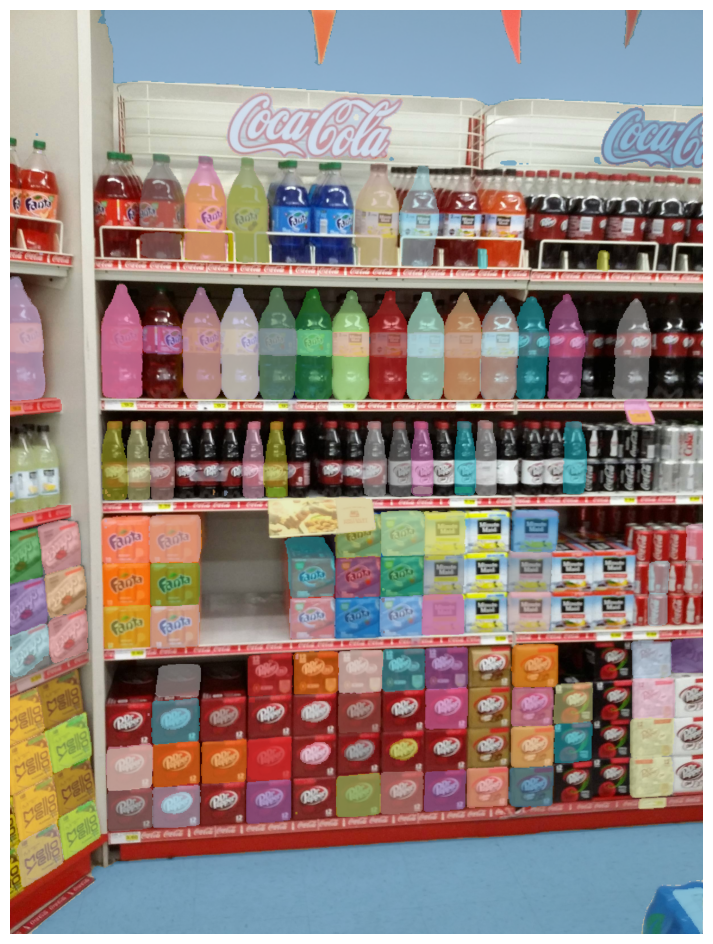

In [9]:
from ultralytics import SAM
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ---- Config ----
image_path = "/kaggle/input/sku110k-annotations/SKU110K_fixed/images/test/test_7.jpg"
MAX_SIZE = 1800       # slightly bigger for more detail
MAX_MASKS = 300       # max number of masks
CONF_THRESH = 0.3     # lower confidence to detect more objects
ALPHA = 0.5           # transparency for mask overlay

# ---- Load SAM2 (auto-downloads small pretrained weights) ----
sam2_model = SAM("sam2_l.pt")

# ---- Read image ----
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
h, w = image.shape[:2]

# ---- Resize if too big ----
scale = MAX_SIZE / max(h, w)
if scale < 1:
    new_w, new_h = int(w*scale), int(h*scale)
    image = cv2.resize(image, (new_w, new_h))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ---- Run SAM2 segmentation with more sensitivity ----
results = sam2_model(image, max_det=MAX_MASKS, conf=CONF_THRESH)

# ---- Get masks ----
masks = results[0].masks.data.cpu().numpy()
print(f"Generated {len(masks)} masks with shape {masks.shape}")

# ---- Create overlay ----
overlay = image.copy()
cmap = cm.get_cmap('tab20', len(masks))  # colormap with enough distinct colors

for i, m in enumerate(masks):
    color = np.array(cmap(i)[:3]) * 255  # RGB 0-255
    color = color.astype(np.uint8)
    mask_bool = m > 0
    overlay[mask_bool] = (overlay[mask_bool] * (1 - ALPHA) + color * ALPHA).astype(np.uint8)

# ---- Visualize full-cover masks ----
plt.figure(figsize=(12,12))
plt.imshow(overlay)
plt.axis('off')
plt.show()


prueba con embedings de clip, migrar a dinov2 o dinov3


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 131, 1 132, 1 133, 1 134, 1 135, 1 136, 1 137, 1 138, 1 139, 1 140, 1 141, 1 142, 1 143, 1 144, 1 145, 1 146, 1 147, 1 148, 1 149, 1 150, 1 151, 1 152, 1 153, 1 154, 1 155, 1 15

Found 1 clusters.


/tmp/ipykernel_55/2663330755.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', max(1, n_clusters))


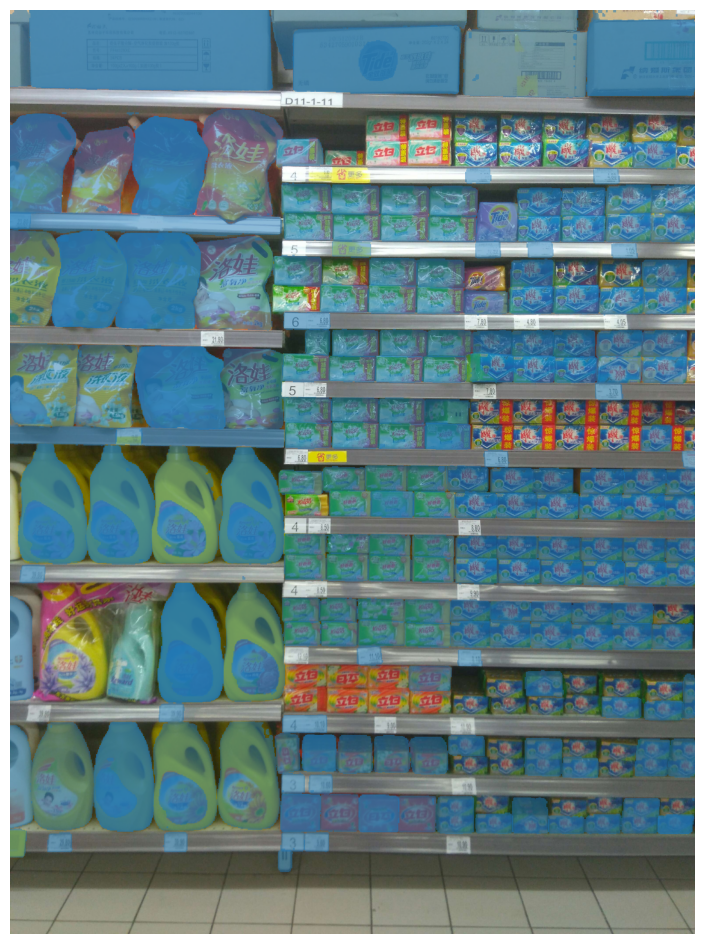

In [10]:
# Install dependencies if not installed
# !pip install git+https://github.com/mlfoundations/open_clip.git
# !pip install ultralytics

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
import open_clip as clip
from PIL import Image
from ultralytics import SAM

# ---- Config ----
IMAGE_PATH = "/kaggle/input/sku110k-annotations/SKU110K_fixed/images/test/test_77.jpg"
MAX_SIZE = 1536       # max image size for GPU
ALPHA = 0.5           # transparency for overlay
DBSCAN_EPS = 0.08     # clustering distance
DBSCAN_MIN_SAMPLES = 2

# ---- Load image ----
image = cv2.imread(IMAGE_PATH)
if image is None:
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")
h, w = image.shape[:2]

# Resize if too big
scale = MAX_SIZE / max(h, w)
if scale < 1:
    new_w, new_h = int(w*scale), int(h*scale)
    image = cv2.resize(image, (new_w, new_h))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ---- Load SAM2 model ----
sam_model = SAM("sam2_l.pt")  # or "sam2_l.pt" if memory allows

# ---- Run SAM2 segmentation ----
# Increase max_det to detect more objects
MAX_MASKS = 300
CONF_THRESH = 0.25
results = sam_model(image_rgb, max_det=MAX_MASKS, conf=CONF_THRESH)

# ---- Extract masks ----
masks = results[0].masks.data.cpu().numpy()  # shape: (num_masks, H, W)
print(f"Generated {len(masks)} masks.")

# ---- Load OpenCLIP ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = clip.create_model_and_transforms("ViT-L-14")
model = model.to(device)

# ---- Compute embedding per mask ----
mask_embeddings = []
valid_masks = []
for m in masks:
    # crop mask area from image
    mask_bool = m > 0
    if mask_bool.sum() == 0:
        continue
    y_indices, x_indices = np.where(mask_bool)
    y1, y2 = y_indices.min(), y_indices.max() + 1
    x1, x2 = x_indices.min(), x_indices.max() + 1
    crop = image_rgb[y1:y2, x1:x2]
    crop_pil = Image.fromarray(crop)
    crop_tensor = preprocess(crop_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(crop_tensor)
        emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize
    mask_embeddings.append(emb.cpu().numpy()[0])
    valid_masks.append((mask_bool, (y1, y2, x1, x2)))

mask_embeddings = np.stack(mask_embeddings)

# ---- Cluster masks by visual similarity ----
clustering = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES, metric="cosine").fit(mask_embeddings)
labels = clustering.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Found {n_clusters} clusters.")

# ---- Create overlay ----
overlay = image_rgb.copy()
cmap = cm.get_cmap('tab20', max(1, n_clusters))

for i, (mask_bool, _) in enumerate(valid_masks):
    label = labels[i]
    if label == -1:
        continue
    color = np.array(cmap(label)[:3]) * 255
    color = color.astype(np.uint8)
    overlay[mask_bool] = (overlay[mask_bool] * (1 - ALPHA) + color * ALPHA).astype(np.uint8)

# ---- Visualize full-cover clusters ----
plt.figure(figsize=(12,12))
plt.imshow(overlay)
plt.axis('off')
plt.show()


test with dinov2 for embeddings

In [12]:
from ultralytics import SAM
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
import timm
from sklearn.cluster import DBSCAN
from PIL import Image

# ---- Config ----
IMAGE_PATH = "/kaggle/input/sku110k-annotations/SKU110K_fixed/images/test/test_7.jpg"
MAX_SIZE = 1800
MAX_MASKS = 400
CONF_THRESH = 0.20
ALPHA = 0.50

# Clustering params (VERY IMPORTANT)
DBSCAN_EPS = 0.20        # smaller = stricter grouping, larger = more merging
DBSCAN_MIN_SAMPLES = 2

# ---- Load image ----
image = cv2.imread(IMAGE_PATH)
if image is None:
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")
h, w = image.shape[:2]

scale = MAX_SIZE / max(h, w)
if scale < 1:
    image = cv2.resize(image, (int(w*scale), int(h*scale)))

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ---- Load SAM3 ----
sam_model = SAM("/kaggle/input/sam3/pytorch/default/1/model.safetensors")

# ---- Run SAM2 ----
results = sam_model(image_rgb, max_det=MAX_MASKS, conf=CONF_THRESH)
masks = results[0].masks.data.cpu().numpy()
print(f"SAM produced {len(masks)} masks")

# ---- Load DINOv2 ----
device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model("vit_large_patch14_dinov2", pretrained=True)
model.eval().to(device)

# DINOv2 preprocessing
def preprocess(img):
    img = cv2.resize(img, (518, 518))
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    img = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)
    return img

# ---- Extract embeddings per mask ----
embeddings = []
valid_masks = []

for m in masks:
    mask_bool = m > 0
    if mask_bool.sum() < 200:  # skip tiny garbage masks
        continue

    ys, xs = np.where(mask_bool)
    y1, y2 = ys.min(), ys.max()+1
    x1, x2 = xs.min(), xs.max()+1

    crop = image_rgb[y1:y2, x1:x2]
    if crop.size == 0:
        continue

    inp = preprocess(crop).to(device)

    with torch.no_grad():
        feat = model(inp)
        feat = torch.nn.functional.normalize(feat, dim=1)

    embeddings.append(feat.cpu().numpy()[0])
    valid_masks.append(mask_bool)

embeddings = np.array(embeddings)
print("Computed embeddings for", len(embeddings), "masks")

# ---- Cluster masks by visual similarity ----
clustering = DBSCAN(
    eps=DBSCAN_EPS,
    min_samples=DBSCAN_MIN_SAMPLES,
    metric="cosine"
).fit(embeddings)

labels = clustering.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Found", n_clusters, "visual groups")

# ---- Paint overlay ----
overlay = image_rgb.copy()
cmap = cm.get_cmap("tab20", max(1, n_clusters))

for i, mask_bool in enumerate(valid_masks):
    label = labels[i]
    if label == -1:
        continue

    color = (np.array(cmap(label)[:3]) * 255).astype(np.uint8)
    overlay[mask_bool] = (overlay[mask_bool] * (1 - ALPHA) + color * ALPHA).astype(np.uint8)

# ---- Show result ----
plt.figure(figsize=(12,12))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"DINOv2 grouping | clusters = {n_clusters}")
plt.show()


NotImplementedError: SAM prediction requires pre-trained *.pt or *.pth model.

tiles

In [ ]:
from ultralytics import SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ---------------- CONFIG ----------------
IMAGE_PATH = "/kaggle/input/sku110k-annotations/SKU110K_fixed/images/test/test_165.jpg"

MAX_SIZE = 3000          # big = better small object detection
TILE = 1024              # tile size
OVERLAP = 256            # overlap between tiles

MAX_MASKS = 400          # per tile
CONF_THRESH = 0.15       # lower = more aggressive
ALPHA = 0.45             # overlay transparency

# ----------------------------------------

# ---- Load image ----
image = cv2.imread(IMAGE_PATH)
if image is None:
    raise FileNotFoundError(IMAGE_PATH)

h0, w0 = image.shape[:2]

# Resize if needed
scale = MAX_SIZE / max(h0, w0)
if scale < 1:
    image = cv2.resize(image, (int(w0*scale), int(h0*scale)))

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
H, W = image.shape[:2]

print("Image size:", H, W)

# ---- Load SAM2 ----
sam = SAM("sam2_l.pt")

# ---- Storage for all masks ----
full_masks = []

# ---- Tiled inference ----
for y in range(0, H, TILE - OVERLAP):
    for x in range(0, W, TILE - OVERLAP):

        y2 = min(y + TILE, H)
        x2 = min(x + TILE, W)

        tile = image[y:y2, x:x2]

        if tile.shape[0] < 128 or tile.shape[1] < 128:
            continue

        print(f"Tile {y}:{y2}, {x}:{x2}")

        results = sam(tile, max_det=MAX_MASKS, conf=CONF_THRESH)

        if results[0].masks is None:
            continue

        masks = results[0].masks.data.cpu().numpy()

        for m in masks:
            full_mask = np.zeros((H, W), dtype=bool)
            mh, mw = m.shape

            full_mask[y:y+mh, x:x+mw] = m > 0
            full_masks.append(full_mask)

print(f"\nTotal masks collected: {len(full_masks)}")

# ---- Visualization ----
overlay = image.copy()

cmap = cm.get_cmap("tab20", max(1, len(full_masks)))

for i, m in enumerate(full_masks):
    color = (np.array(cmap(i)[:3]) * 255).astype(np.uint8)
    overlay[m] = (overlay[m] * (1 - ALPHA) + color * ALPHA).astype(np.uint8)

plt.figure(figsize=(12,12))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Tiled SAM2 — {len(full_masks)} masks")
plt.show()


tile deduplication

In [ ]:
from ultralytics import SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ---------------- CONFIG ----------------
IMAGE_PATH = "/kaggle/input/sku110k-annotations/SKU110K_fixed/images/test/test_165.jpg"

MAX_SIZE = 3000
TILE = 1024
OVERLAP = 256

MAX_MASKS = 400
CONF_THRESH = 0.15
ALPHA = 0.45

IOU_THRESH = 0.5   # threshold for merging duplicates

# ----------------------------------------

def mask_iou(m1, m2):
    inter = np.logical_and(m1, m2).sum()
    union = np.logical_or(m1, m2).sum()
    if union == 0:
        return 0
    return inter / union

# ---- Load image ----
image = cv2.imread(IMAGE_PATH)
if image is None:
    raise FileNotFoundError(IMAGE_PATH)

h0, w0 = image.shape[:2]
scale = MAX_SIZE / max(h0, w0)
if scale < 1:
    image = cv2.resize(image, (int(w0*scale), int(h0*scale)))

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
H, W = image.shape[:2]

print("Image size:", H, W)

# ---- Load SAM2 ----
sam = SAM("sam2_l.pt")

# ---- Storage for merged masks ----
merged_masks = []

# ---- Tiled inference + merging ----
for y in range(0, H, TILE - OVERLAP):
    for x in range(0, W, TILE - OVERLAP):

        y2 = min(y + TILE, H)
        x2 = min(x + TILE, W)

        tile = image[y:y2, x:x2]

        if tile.shape[0] < 128 or tile.shape[1] < 128:
            continue

        print(f"Tile {y}:{y2}, {x}:{x2}")

        results = sam(tile, max_det=MAX_MASKS, conf=CONF_THRESH)

        if results[0].masks is None:
            continue

        masks = results[0].masks.data.cpu().numpy()

        for m in masks:
            full_mask = np.zeros((H, W), dtype=bool)
            mh, mw = m.shape
            full_mask[y:y+mh, x:x+mw] = m > 0

            # ---- MERGE STEP ----
            is_new = True
            for i, existing in enumerate(merged_masks):
                iou = mask_iou(full_mask, existing)
                if iou > IOU_THRESH:
                    # same object -> merge masks
                    merged_masks[i] = np.logical_or(existing, full_mask)
                    is_new = False
                    break

            if is_new:
                merged_masks.append(full_mask)

print(f"\nFinal unique objects: {len(merged_masks)}")

# ---- Visualization ----
overlay = image.copy()
cmap = cm.get_cmap("tab20", max(1, len(merged_masks)))

for i, m in enumerate(merged_masks):
    color = (np.array(cmap(i)[:3]) * 255).astype(np.uint8)
    overlay[m] = (overlay[m] * (1 - ALPHA) + color * ALPHA).astype(np.uint8)

plt.figure(figsize=(12,12))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Tiled SAM2 merged — {len(merged_masks)} objects")
plt.show()


test quantization idea k means

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---- Quantization function ----
def quantize_image(image, n_colors=8):
    # Flatten image
    Z = image.reshape((-1, 3)).astype(np.float32)

    # KMeans clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    quantized = centers[labels.flatten()]
    quantized = quantized.reshape((image.shape))
    return quantized

# ---- Step 1: Quantize colors ----
image_quant = quantize_image(image_rgb, n_colors=16)

# ---- Step 2: Apply median filter to smooth small noise ----
MEDIAN_KSIZE = 5  # adjust: higher = smoother regions
image_smooth = cv2.medianBlur(image_quant, MEDIAN_KSIZE)

# ---- Display the result ----
plt.figure(figsize=(12, 12))
plt.imshow(image_smooth)
plt.axis('off')
plt.title("Quantized + Smoothed Image (10 colors)")
plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb

# ---- Config ----
IMAGE_PATH = "/kaggle/input/sku110k-annotations/SKU110K_fixed/images/test/test_7.jpg"
N_SEGMENTS = 200      # number of superpixels
COMPACTNESS = 20       # higher = more square-ish superpixels

# ---- Load image ----
image = cv2.imread(IMAGE_PATH)
if image is None:
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ---- Apply SLIC superpixel segmentation ----
segments = slic(image_rgb, n_segments=N_SEGMENTS, compactness=COMPACTNESS)

# ---- Create average-color superpixel image ----
image_slic = label2rgb(segments, image_rgb, kind='avg')

for n_segments in [100, 200, 400]:
    for compactness in [5, 10, 20]:
        segments = slic(image_rgb, n_segments=n_segments, compactness=compactness)
        image_slic = label2rgb(segments, image_rgb, kind='avg')
        plt.figure(figsize=(8,8))
        plt.imshow(image_slic)
        plt.axis('off')
        plt.title(f"n_segments={n_segments}, compactness={compactness}")
        plt.show()


In [ ]:
from ultralytics import SAM
import cv2
import matplotlib.pyplot as plt

# ---- Configuración ----
checkpoint_path = "/kaggle/input/tu-checkpoint/sam3.safetensors"  # path a tu .safetensors
image_path = "/kaggle/input/tu-dataset/SECCION-BEBIDAS-1.jpg"     # path a tu imagen

# ---- Cargar modelo ----
sam3_model = SAM(checkpoint_path)

# ---- Crear generador automático de máscaras ----
mask_generator = sam3_model.automatic_mask_generator()

# ---- Leer imagen ----
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ---- Generar máscaras automáticamente ----
masks = mask_generator.generate(image)
print(f"Se generaron {len(masks)} máscaras")


In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(image)

for mask in masks:
    plt.contour(mask['segmentation'], colors='r', linewidths=1)

plt.axis('off')
plt.show()

In [ ]:
from sam import SAM3

#emejplo conceptial donde no hace falta lvm
#sam usa nombres genericos no marcas
sam3_model = SAM3(pretrained=True)

# Pedimos segmentar “coca_can”
masks = sam3_model.segment(image, prompt="coca_can")

# Ahora ya tenemos las máscaras de la clase que pedimos


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from safetensors.torch import load_file
from ultralytics import SAM

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# --------------------------------------------------
# Load test image (Ultralytics sample)
# --------------------------------------------------
img = Image.open("/kaggle/input/input1/input/SECCION-BEBIDAS-5.jpg").convert("RGB")
img_np = np.array(img)

# --------------------------------------------------
# 1️⃣ Load Ultralytics SAM-2
# --------------------------------------------------
sam2 = SAM("sam2_b.pt")     # auto-downloads
sam2.model.to(device)

sam2_res = sam2(img_np, verbose=False)[0]
sam2_mask = sam2_res.masks.data.any(0).cpu().numpy()

sam2_out = img_np.copy()
sam2_out[sam2_mask] = sam2_out[sam2_mask] * 0.4 + np.array([255,0,0]) * 0.6

# --------------------------------------------------
# 2️⃣ Load your SAM-3 (safetensors)
# --------------------------------------------------
sam3_path = "/kaggle/input/sam3pt/pytorch/default/1/sam3.pt"

sam3 = SAM(sam3_path)
sam3.model.to(device)

sam3_res = sam3(img_np, verbose=False)[0]
sam3_mask = sam3_res.masks.data.any(0).cpu().numpy()

sam3_out = img_np.copy()
sam3_out[sam3_mask] = sam3_out[sam3_mask] * 0.4 + np.array([0,255,0]) * 0.6

# --------------------------------------------------
# 3️⃣ Display 1×2 grid
# --------------------------------------------------
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title("SAM-3 (your model)")
plt.imshow(sam3_out)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("SAM-2 (Ultralytics pretrained)")
plt.imshow(sam2_out)
plt.axis("off")

plt.show()

In [ ]:
del sam2_res, sam2_mask, sam2_out
del sam3_res, sam3_mask, sam3_out
torch.cuda.empty_cache()  # releases cached memory to GPU
